In [3]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],timeout=60)

In [5]:
#Get indices for rucio-events*
indices = es.cat.indices(index="rucio-events*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

In [6]:
def getFieldWithTimestamp(_src,_dst,field,eventType,period,binSize,aggType):
    '''
    This function, given a properly built query, gets the desired field value and timestamps (in milliseconds from
    Epoch). Requires a query to be built by the buildFieldWithTimestampQuery() function.
    '''
    query = buildFieldWithTimestampQuery(_src,_dst,field,eventType,period,binSize,aggType)
    response = es.search(index="rucio-events*", body=query, request_timeout=600)
    #Initialize lists
    fieldVals = []
    timestamp = []
    
    #For each bucket:
    for r in response['aggregations']['2']['buckets']:
        
        #Get field value and timestamp
        fieldVals.append(r['3']['value'])
        timestamp.append(r['key'])
        
    #Convert both to numpy arrays
    timestamp = np.array(timestamp)
    fieldVals = np.array(fieldVals)
    
    return fieldVals, timestamp

In [7]:
import ast

def buildFieldWithTimestampQuery(_src,_dst,field,eventType,period,binSize,aggType):
    '''
    This function builds a query to feed to the getFieldwithTimestamp() function. It requires the following input parameters:
    _src: [str] The source data center, e.g. "CERN-PROD*" (note that this query accepts wildcards).
    _dst: [str] The destination data center, e.g. "BNL*".
    field: [str] The desired field of data. Examples include "payload.bytes","payload.duration", and "payload.file-size".
    eventType: [str] Filters the data based on event type. A list of some possibilities: "transfer-submitted", "transfer-done",
        "transfer-failed", "transfer-waiting", and "*" (grabs field from all event types, if it exists).
    period: [str] The period of time over which the field is acquired. For example, "7d" would grab a week of data from the
        current time.
    binSize: [str] The period of time that each histogram bin spans. For example, "1h" bins the data hourly.
    aggType: [str] Method to aggregate data. Examples include "sum", "avg", "max", "min", "cardinality" (for unique count).
    
    '''
    queryTemplate= """{
      "query": {
        "filtered": {
          "query": {
            "query_string": {
              "query": "payload.src-rse:%s* AND payload.dst-rse:%s* AND event_type:%s",
              "analyze_wildcard": True,
              "lowercase_expanded_terms": False
            }
          },
          "filter": {
            "bool": {
              "must": [
                {
                  "range": {
                    "@timestamp": {
                      "gte": 'now-%s',
                      "lte": 'now',
                      "format": "epoch_millis"
                    }
                  }
                }
              ],
              "must_not": []
            }
          }
        }
      },
      "size": 0,
      "aggs": {
        "2": {
          "date_histogram": {
            "field": "@timestamp",
            "interval": "%s",
            "time_zone": "Europe/Berlin",
            "min_doc_count": 1,
            "extended_bounds": {
              "min": 'now-%s',
              "max": 'now'
            }
          },
          "aggs": {
            "3": {
              "%s": {
                "field": "%s"
              }
            }
          }
        }
      }
    }"""

    builtQuery = ast.literal_eval(queryTemplate%(_src,_dst,eventType,period,binSize,period,aggType,field))
    return builtQuery

In [8]:
def getCountWithTimestamp(_src,_dst,eventType,period,binSize):
    '''
    Getting a count value requires a different query format then getting field values, so I created a separate function
    for this utility. This function requires the following input parameters:
        _src: [str] The source data center, e.g. "CERN-PROD*" (note that this query accepts wildcards).
        _dst: [str] The destination data center, e.g. "BNL*".
        period: [str] The period of time over which the field is acquired. For example, "7d" would grab a week of data from the
            current time.
        binSize: [str] The period of time that each histogram bin spans. For example, "1h" bins the data hourly.
    
    Outputs:
        countVals: The number of events for the desired period.
        timestamp: Corresponding time values, in milli-epochs.
    '''
    queryTemplate = """{
      "size": 0,
      "query": {
        "filtered": {
          "query": {
            "query_string": {
              "analyze_wildcard": True,
              "lowercase_expanded_terms": False,
              "query": "payload.src-rse:%s AND payload.dst-rse:%s AND event_type:%s"
            }
          },
          "filter": {
            "bool": {
              "must": [
                {
                  "range": {
                    "@timestamp": {
                        "gte": 'now-%s',
                        "lte": 'now',
                      "format": "epoch_millis"
                    }
                  }
                }
              ],
              "must_not": []
            }
          }
        }
      },
      "aggs": {
        "3": {
          "date_histogram": {
            "field": "@timestamp",
            "interval": "%s",
            "time_zone": "Europe/Berlin",
            "min_doc_count": 1,
            "extended_bounds": {
                "min": 'now-%s',
                "max": 'now'
            }
          }
        }
      }
    }"""

    #Initialize lists
    countVals = []
    timestamp = []

    
    builtQuery = ast.literal_eval(queryTemplate%(_src,_dst,eventType,period,binSize,period))
    response = es.search(index="rucio-events*", body=builtQuery, request_timeout=600)

    #For each bucket:
    for r in response['aggregations']['3']['buckets']:
        countVals.append(r['doc_count'])
        timestamp.append(r['key'])

    countVals = np.array(countVals)
    timestamp = np.array(timestamp)

    return countVals,timestamp


In [13]:
def getHistogramData(_src,_dst,period,binSize):
    #Acquire data for throughput calculation
    field = "payload.bytes"
    eventType = "transfer-submitted"
    aggType = "avg"

    payloadBytes,payloadTimestamp = getFieldWithTimestamp(_src,_dst,field,eventType,period,binSize,aggType)
    print("Obtained bytecount data over chosen timerange (length %s)."%str(len(payloadBytes)))
    
    #Acquire data for duration display

    field = "payload.duration"
    eventType = "transfer-done"
    aggType = "avg"
    payloadDuration,_ = getFieldWithTimestamp(_src,_dst,field,eventType,period,binSize,aggType)
    print("Obtained duration data over chosen timerange (length %s)."%str(len(payloadDuration)))
    # Get number of queued values
    eventType = "transfer-submitted"

    countVals,_ = getCountWithTimestamp(_src,_dst,eventType,period,binSize)
    print("Obtained # of queued files over chosen timerange (length %s)."%str(len(countVals)))
    
    return payloadBytes, payloadTimestamp,payloadDuration,countVals

In [37]:
#Need to replace None with NaN (Why are these blank anyways?)
def convertNoneToNan(arr):
    for i in range(len(arr)):
        if arr[i] is None:
                   arr[i] = np.nan
    return arr


Obtained bytecount data over chosen timerange (length 60).
Obtained duration data over chosen timerange (length 60).
Obtained # of queued files over chosen timerange (length 60).


In [88]:
import re
def binSizeToTimescale(binSize):
    '''
    This function expects binSize strings like "12h" and "4d". Used to convert throughput
    units to MB per second based on bin size
    '''
    numeric=re.findall(r'\d+',binSize)
    numVal = int(numeric[0])
    if binSize[len(binSize)-1] == 'h':
        timeScaling = (60**2)*numVal
    elif binSize[len(binSize)-1] == 'd':
        timeScaling = (60**2*24)*numVal
    
    return timeScaling


In [87]:
print(binSizeToTimescale("12h"))
print(60*60*12)

43200
43200


Obtained bytecount data over chosen timerange (length 60).
Obtained duration data over chosen timerange (length 60).
Obtained # of queued files over chosen timerange (length 60).


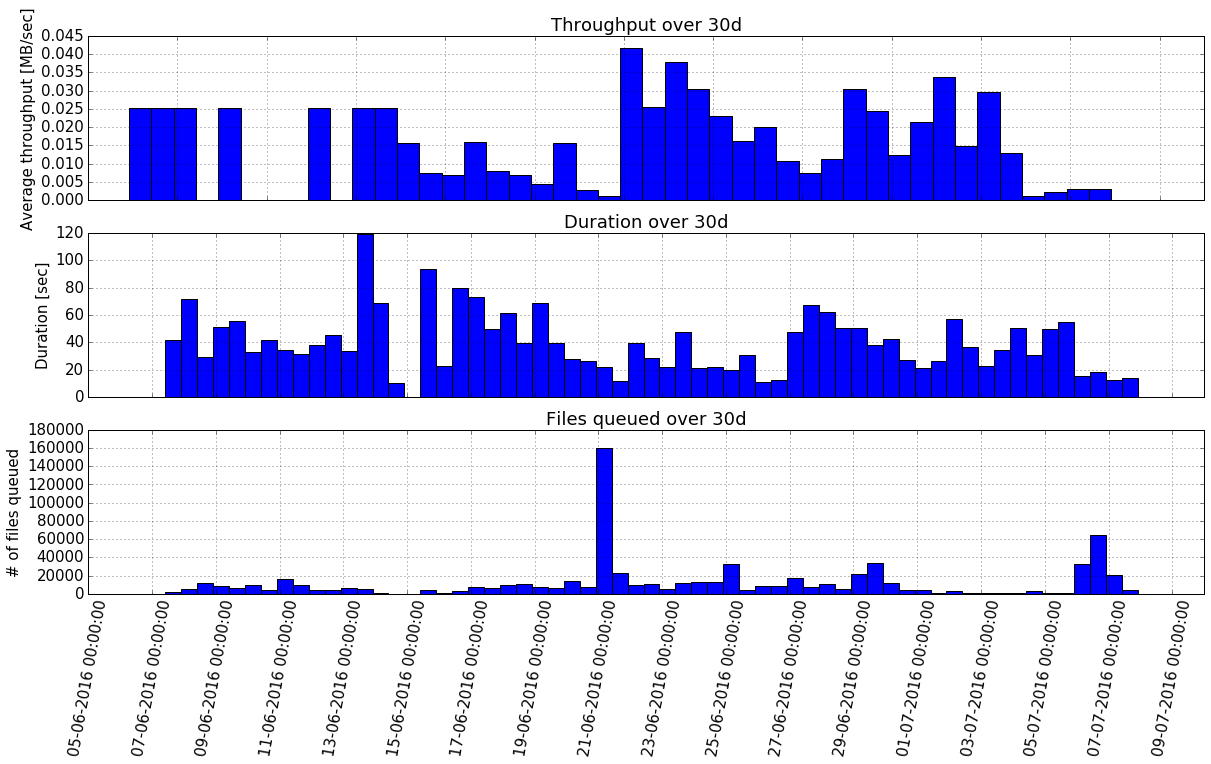

In [97]:
import matplotlib.dates as dt

_src = 'IN2P3*'
_dst = 'BNL*'
period = "30d"
binSize = "12h"

payloadBytes, payloadTimestamp,payloadDuration,countVals = getHistogramData(_src,_dst,period,binSize)
payloadBytes = convertNoneToNan(payloadBytes)

#Get throughput            1E-6 MB/B  
throughput = payloadBytes*(1E-6)/binSizeToTimescale(binSize) #units in MB/sec

#Manually add extra ticks to histogram plots
ticks = 2 

#First plot
times = dt.epoch2num(payloadTimestamp/1000.)
width = times[1] - times[0]

plt.figure(figsize=(20,10))
plt.subplot(311)
plt.bar(times,throughput,width=width)
plt.grid()
plt.title('Throughput over %s'%period)
plt.ylabel('Average throughput [MB/sec]')
ax=plt.gca()

#Don't display the xtick labels for this plot
ax.xaxis.set_major_formatter(plt.NullFormatter())

start, end = ax.get_xlim()
#Place extra xticks manually (change 1/4 to something different)
plt.xticks(np.arange(start, end,ticks),rotation= 80 )

#Second plot
plt.subplot(312)
plt.bar(times,payloadDuration,width=width)
plt.grid()
plt.title('Duration over %s'%period)
plt.ylabel('Duration [sec]')
ax=plt.gca()

#Don't display the xtick labels for this plot either
ax.xaxis.set_major_formatter(plt.NullFormatter())

start, end = ax.get_xlim()
#Place extra xticks manually (change 1/4 to something different)
plt.xticks(np.arange(start, end,ticks),rotation= 80 )



#Third plot
plt.subplot(313)
plt.bar(times,countVals,width=width)
plt.grid()
plt.title('Files queued over %s'%period)
plt.ylabel('# of files queued')
ax=plt.gca()

#Tedious date/time formatting
xfmt = dt.DateFormatter('%d-%m-%Y %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

start, end = ax.get_xlim()
#Place extra xticks manually (change 1/4 to something different)
plt.xticks(np.arange(start, end,ticks),rotation= 80 )
plt.show()


Graphing # of files vs. throughput, it looks like a linear relation, with the exception of some outliers. What are these outliers?

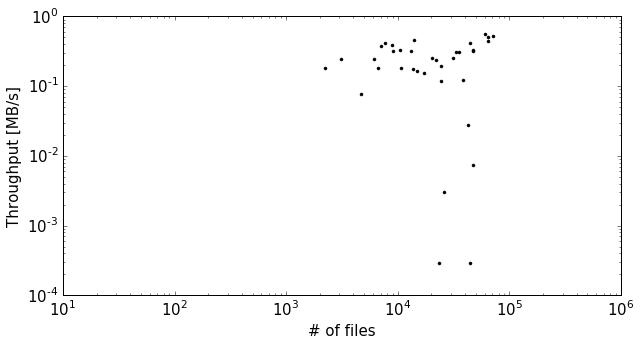

In [63]:
plt.figure(figsize=(10,5))
plt.loglog(countVals,throughputWeek,'k.')
plt.xlabel('# of files')
plt.ylabel('Throughput [MB/s]')

In [ ]:
G = np.corrcoef(countVals,throughputWeek)

In [ ]:
G